In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Criterios de filtro
- filtrar genomas con datos NaN en las columnas HC5, Collection Year y Source Niche
- filtrar genomas con datos duplicados en las tres columnas HC5, Collection Year y Source Niche

In [2]:
df = pd.read_excel("db/Salmonella_Chile_201124.xlsx")
print(df.columns)
print(df.shape[0])
df = df.dropna(subset=['HC5', 'Collection Year', 'Source Niche'])
print(df.shape[0])
df = df.drop_duplicates(subset=['HC5', 'Collection Year', 'Source Niche'])
print(f"Genomas totales: {df.shape[0]}")
df["Collection Year"] = df["Collection Year"].astype(int)
df["HC20"] = df["HC20"].astype(int)
df["HC50"] = df["HC50"].astype(int)
df["Collection Year"] = df["Collection Year"].astype(str)
df["HC20"] = df["HC20"].astype(str)
df["HC50"] = df["HC50"].astype(str)
df = df[['Assembly Barcode', 'SISTR1 Serovar', 'HC20', 'HC50', 'Source Niche', 'Collection Year']]
df.to_csv(os.path.join("out", "Salmonella_Chile_201124_filt.tsv"), index=False, sep='\t')
df

Index(['Uberstrain', 'Name',
       'Data Source(Accession No.;Sequencing Platform;Sequencing Library;Insert Size;Experiment;Bases;Average Length;Status)',
       'Barcode', 'Source Niche', 'Source Type', 'Source Details',
       'Collection Year', 'Collection Month', 'Collection Day',
       'Collection Time', 'Continent', 'Country', 'Region', 'District', 'City',
       'Post Code', 'Latitude', 'Longitude', 'Serovar', 'Subspecies',
       'Disease', 'Antigenic Formulas', 'Phage Type', 'Lab Contact', 'Comment',
       'Bio Project ID', 'Project ID', 'Sample ID', 'Secondary Sample ID',
       'Date Entered', 'Release Date', 'ST', 'eBG', 'Serotype (Predicted)',
       'Lineage', 'Subspecies.1', 'aroC', 'dnaN', 'hemD', 'hisD', 'purE',
       'sucA', 'thrA', 'cgST', 'HC0 (indistinguishable)', 'HC2', 'HC5', 'HC10',
       'HC20', 'HC50', 'HC100', 'HC200', 'HC400', 'HC900 (ceBG)',
       'HC2000 (Super-lineage)', 'HC2600', 'HC2850 (subsp.)', 'SISTR1 Serovar',
       'SISTR1 Serogroup', 'SIST

,Assembly Barcode,SISTR1 Serovar,HC20,HC50,Source Niche,Collection Year
8,SAL_IA5729AA_AS,Typhimurium,305,305,Livestock,2006
9,SAL_EA4360AA_AS,Anatum,34548,7,Livestock,2006
10,SAL_CA3641AA_AS,Newport,17481,17481,Aquatic Animal,2005
11,SAL_JA4500AA_AS,Typhimurium,14886,293,Livestock,2004
12,SAL_JA6717AA_AS,Typhimurium,17777,1585,Human,1945
...,...,...,...,...,...,...
3439,SAL_RD3113AA_AS,Panama,227671,227671,Food,2024
3440,SAL_RD3114AA_AS,Infantis,343,36,Food,2024
3441,SAL_RD3115AA_AS,Infantis,343,36,Food,2024
3445,SAL_RD3120AA_AS,Infantis,343,36,Food,2024


In [3]:
"""
Extraer Assembly Barcode para descargar assemblies
"""
df["Assembly Barcode"].to_csv(os.path.join("out", "barcode_assemblies.txt"), index=False, sep='\t', header=False)

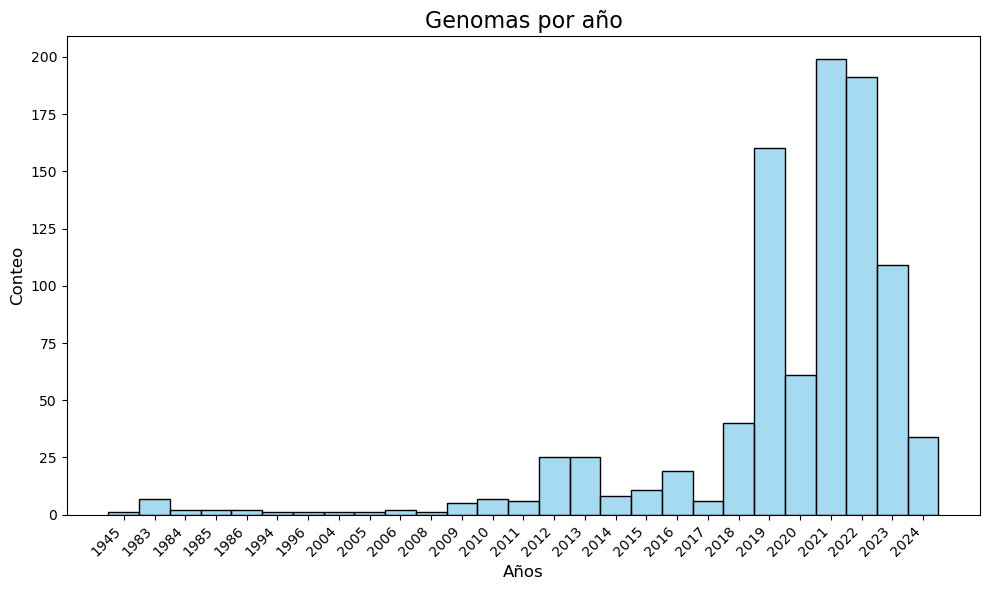

In [4]:
year_count = df.sort_values(by='Collection Year').reset_index(drop=True)
plt.figure(figsize=(10, 6))
sns.histplot(year_count['Collection Year'], color='skyblue')

plt.xticks(rotation=45, ha='right')
plt.title('Genomas por año', fontsize=16)
plt.xlabel('Años', fontsize=12)
plt.ylabel('Conteo', fontsize=12)

plt.tight_layout()
save = os.path.join("img", "histograma_genomas_by_Collection_Year.png")
plt.savefig(save, format='png')
plt.show()

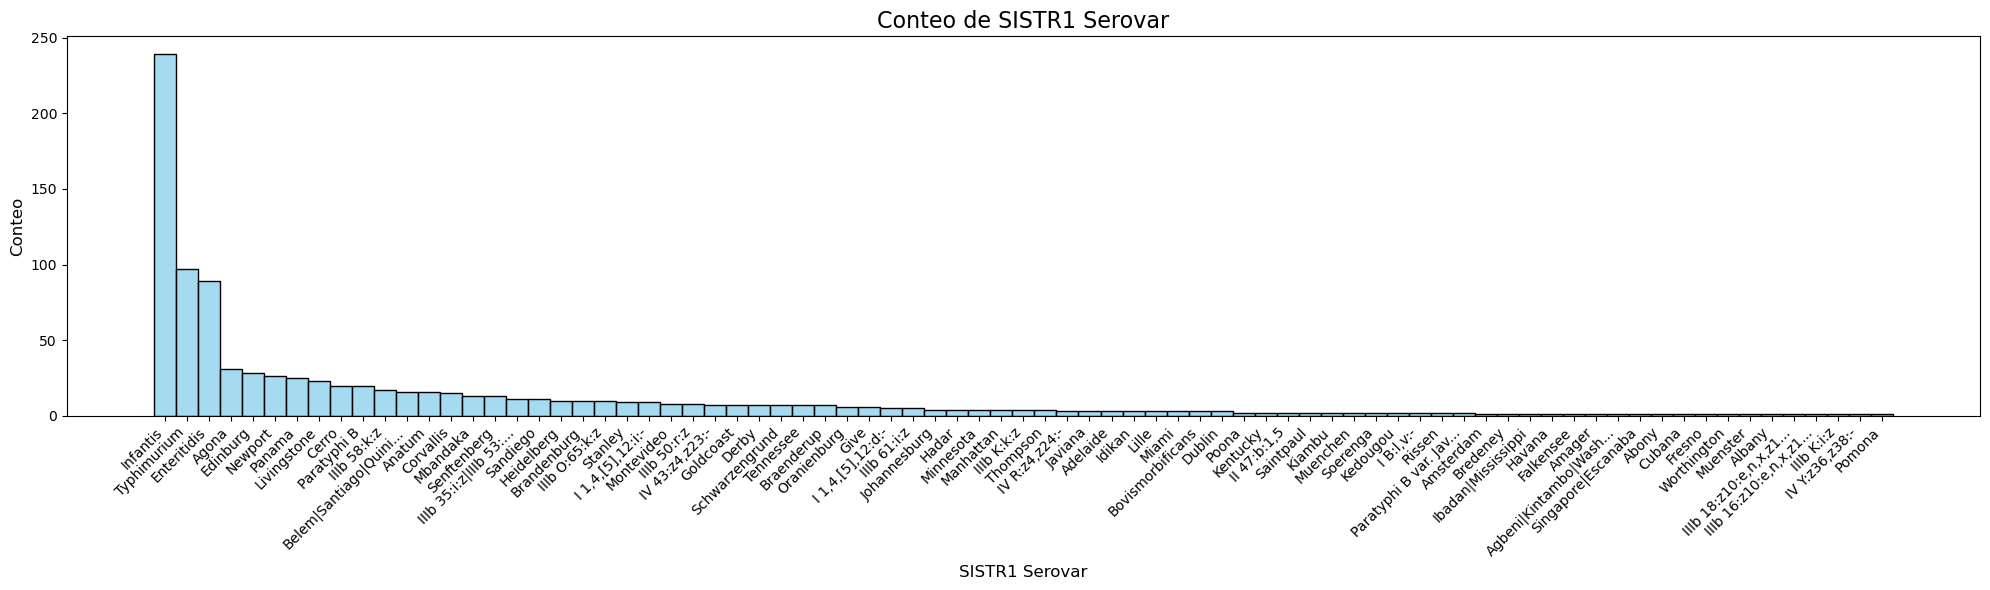

In [14]:
def truncar(s):
    l = 20
    if len(s) > l:
        return s[:l] + '...'
    return s

df_truncado = df.copy()
df_truncado['SISTR1 Serovar'] = df['SISTR1 Serovar'].apply(truncar)
sorted_categories = df_truncado['SISTR1 Serovar'].value_counts().index
df_truncado['SISTR1 Serovar'] = pd.Categorical(df_truncado['SISTR1 Serovar'], categories=sorted_categories, ordered=True)

plt.figure(figsize=(20, 6))
sns.histplot(df_truncado['SISTR1 Serovar'], color='skyblue')

plt.xticks(rotation=45, ha='right')
plt.title('Conteo de SISTR1 Serovar', fontsize=16)
plt.xlabel('SISTR1 Serovar', fontsize=12)
plt.ylabel('Conteo', fontsize=12)

plt.tight_layout()
save = os.path.join("img", "histograma_total_serotipos.png")
plt.savefig(save, format="png", dpi=900)
plt.show()

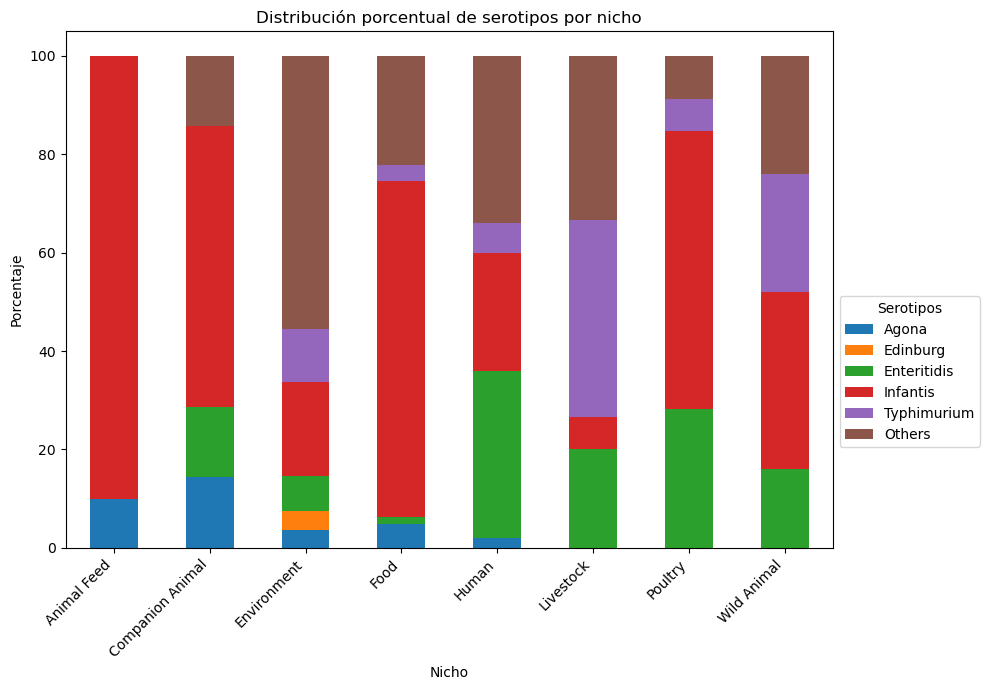

In [13]:
"""
Los serotipos mas frecuentes por fuente de aislamiento
"""
frequent_serovars = ['Infantis', 'Typhimurium', 'Enteritidis', 'Agona', 'Edinburg']
frequent_serovars_by_niche = df[df['SISTR1 Serovar'].isin(frequent_serovars)]
frequent_serovars_count = frequent_serovars_by_niche.groupby(['Source Niche', 'SISTR1 Serovar']).size().unstack(fill_value=0)
# Columna de menos frecuentes
not_important_serovars_count = df[~df['SISTR1 Serovar'].isin(frequent_serovars)]
source_niche_counts = not_important_serovars_count['Source Niche'].value_counts().reset_index()
source_niche_counts.columns = ['Source Niche', 'Others']
source_niche_counts = source_niche_counts.set_index('Source Niche')
# df de ambos conteos
total_counts = pd.merge(frequent_serovars_count, source_niche_counts, on='Source Niche', how='left')
total_counts['Others'] = total_counts['Others'].fillna(0)
total_counts['Others'] = total_counts['Others'].astype(int)
# Plot
df_percent = total_counts.div(total_counts.sum(axis=1), axis=0) * 100
df_percent.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.legend(title='Serotipos', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Nicho')
plt.ylabel('Porcentaje')
plt.title('Distribución porcentual de serotipos por nicho')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
save = os.path.join("img", "stackedplot_serotipos_por_nicho.png")
plt.savefig(save, dpi=900, format="png")
plt.show()

In [7]:
total_counts

,Agona,Edinburg,Enteritidis,Infantis,Typhimurium,Others
Source Niche,,,,,,
Animal Feed,1,0,0,9,0,0
Companion Animal,1,0,1,4,0,1
Environment,25,28,50,135,77,393
Food,3,0,1,43,2,14
Human,1,0,17,12,3,17
Livestock,0,0,3,1,6,5
Poultry,0,0,13,26,3,4
Wild Animal,0,0,4,9,6,6


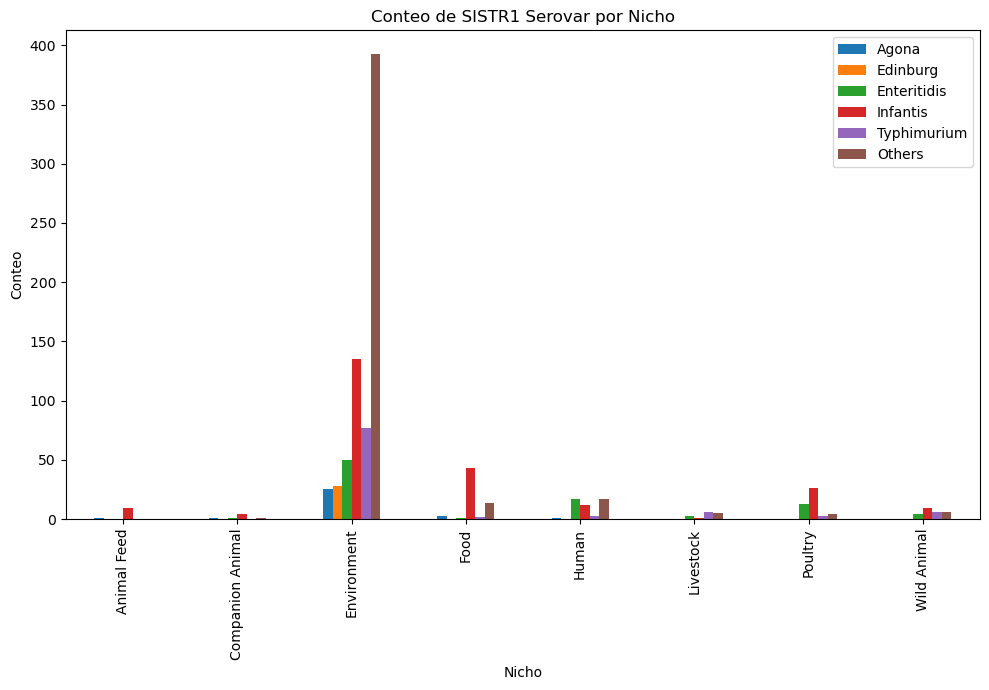

In [8]:
total_counts.plot(kind='bar', stacked=False, figsize=(10, 7))
#counts = frequent_serovars_by_niche.groupby(['Source Niche', 'SISTR1 Serovar']).size().unstack(fill_value=0)
#counts.plot(kind='bar', stacked=False, figsize=(10, 7))

plt.xlabel('Nicho')
plt.ylabel('Conteo')
plt.title('Conteo de SISTR1 Serovar por Nicho')

plt.tight_layout()
save = os.path.join("img", "group_serotipos_por_nicho.png")
plt.savefig(save, format='png')
plt.show()